In [1]:
import os
import wandb
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from torch import optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from prettytable import PrettyTable
import matplotlib.font_manager as fm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

# This used to print malayalam words when heatmap is ploted
malayalam_font = fm.FontProperties(fname='/kaggle/input/malayalam-font/Noto_Serif_Malayalam/NotoSerifMalayalam-VariableFont_wght.ttf')

warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
os.environ['WANDB_API_KEY'] = '1ffc33d77af0fd022201ec32b81cd0e92cd75821'
wandb.login()

#1ffc33d77af0fd022201ec32b81cd0e92cd75821

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alandandoor (alandandoor-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
SOW_token = 0
EOW_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.n_letters = 2 # Count SOW and EOW
        self.letter2index = {}
        self.letter2count = {}
        self.index2letter = {0: "0", 1: "1"}

    def addWord(self, word):
        for ch in word:
            self.addLetter(ch)

    def addLetter(self, ch):
        if ch not in self.letter2index:
            self.letter2index[ch] = self.n_letters
            self.letter2count[ch] = 1
            self.index2letter[self.n_letters] = ch
            self.n_letters += 1
        else:
            self.letter2count[ch] += 1

input_lang = Lang('eng')
output_lang = Lang('mal')
x_train = pd.read_csv('/kaggle/input/malayalam/ml/lexicons/ml.translit.sampled.train.tsv', sep='\t', header=None) #, nrows=1000)
x_val = pd.read_csv('/kaggle/input/malayalam/ml/lexicons/ml.translit.sampled.dev.tsv', sep='\t', header=None)
x_test = pd.read_csv('/kaggle/input/malayalam/ml/lexicons/ml.translit.sampled.test.tsv', sep='\t', header=None)


In [4]:
MAX_LENGTH = 50

def indexesFromWord(lang, word):
    return [lang.letter2index[ch] for ch in word]

def tensorFromWord(lang, word):
    indexes = indexesFromWord(lang, word)
    indexes.append(EOW_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def wordFromTensor(lang, tensor):
    s = ""
    for i in tensor:
        if(i.item()==1):
            break
        s += lang.index2letter[i.item()] 
    return s

def get_dataloader(x, input_lang, output_lang, batch_size):
    pairs = list(zip(x[1].values, x[0].values))  # Get list of (input, target) tuples
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for i, (inp, tgt) in enumerate(pairs):
        if not isinstance(inp, str) or not isinstance(tgt, str):
            continue  # skip malformed entries

        input_lang.addWord(inp)
        output_lang.addWord(tgt)
        inp_ids = indexesFromWord(input_lang, inp)
        tgt_ids = indexesFromWord(output_lang, tgt)
        inp_ids.append(EOW_token)
        tgt_ids.append(EOW_token)
        input_ids[i, :len(inp_ids)] = inp_ids
        target_ids[i, :len(tgt_ids)] = tgt_ids

    input_lengths = (input_ids != 0).astype(np.uint8)
    input_lengths = torch.BoolTensor(input_lengths).to(device)
    
    data = TensorDataset(torch.LongTensor(input_ids).to(device),torch.LongTensor(target_ids).to(device),input_lengths)

    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dataloader

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, config, input_size):
        super(EncoderRNN, self).__init__()
        
        self.embedding = nn.Embedding(input_size, config.inp_embed_size)
        self.algo = algorithms[config.cell_type](config.inp_embed_size, config.hidden_size, batch_first=True)
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, input):
        output, hidden = self.algo(self.dropout(self.embedding(input)))
        return output, hidden

In [6]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys, mask=None):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))  # (B, T, 1)
        scores = scores.squeeze(2).unsqueeze(1)  # (B, 1, T)
    
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(1) == 0, -1e9)
    
        weights = F.softmax(scores, dim=-1)  # (B, 1, T)
        context = torch.bmm(weights, keys)   # (B, 1, H)
        return context, weights


class AttnDecoderRNN(nn.Module):
    def __init__(self, config, output_size):
        super(AttnDecoderRNN, self).__init__()
        
        self.dropout_p = config.dropout
        hidden_size = config.hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = Attention(hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.algo = algorithms[config.cell_type](hidden_size + hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(self.dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None, src_mask=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOW_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(decoder_input, decoder_hidden, encoder_outputs) # , src_mask
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        # Ensure `embedded` has shape [B, 1, H]
        if embedded.dim() == 2:
            embedded = embedded.unsqueeze(1)  # [B, 1, H]
        elif embedded.dim() == 4:
            embedded = embedded.squeeze(1)  # Remove accidental extra dim


         # Unpack hidden state if using LSTM
        if isinstance(hidden, tuple):
            h = hidden[0]  # (num_layers, batch, hidden_size)
        else:
            h = hidden
    
        query = h.permute(1, 0, 2)  # (batch, num_layers, hidden_size)

        context, attn_weights = self.attention(query, encoder_outputs)
        # Ensure `context` has shape [B, 1, H]
        if context.dim() == 2:
            context = context.unsqueeze(1)
        elif context.dim() == 4:
            context = context.squeeze(1)
    
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.algo(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [7]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, batch_size, teacher_forcing = True):

    total_loss = 0
    correct = 0
    total = 0

    for data in dataloader:
        input_tensor, target_tensor, src_mask = data 
        # input_tensor, target_tensor = data

        target_tensor2 = None
        if (teacher_forcing):
            target_tensor2 = target_tensor

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        
        decoder_outputs, _, attentions = decoder(encoder_outputs, encoder_hidden, target_tensor, src_mask)
        # decoder_outputs, _, attentions = decoder(encoder_outputs, encoder_hidden, target_tensor2)

        outputs = decoder_outputs.view(-1, decoder_outputs.size(-1))
        labels = target_tensor.view(-1)

        loss = criterion(outputs, labels)
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)

        seq_len = target_tensor.size(1)  # Typically MAX_LENGTH
        actual_batch_size = target_tensor.size(0)
        flat_len = predicted.size(0)
        
        for i in range(actual_batch_size):
            start = i * seq_len
            end = start + seq_len
            if end > flat_len:
                break  # Avoid out-of-bounds
            if torch.equal(predicted[start:end], labels[start:end]):
                correct += 1
        total += actual_batch_size

    return total_loss / len(dataloader), (correct*100) / total

In [8]:
def train(train_dataloader, val_dataloader, test_dataloader, encoder, decoder, n_epochs, config):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=config.lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=config.lr)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        print("Epoch:",epoch)
        loss, acc = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, config.batch_size)
        print("Train: accuracy:", acc, "loss:", loss)
        if(acc<0.01 and epoch>=15):
            break
        val_loss, val_acc = train_epoch(val_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, config.batch_size, teacher_forcing=False)
        print("Validation: accuracy:", val_acc, "Loss:", val_loss)
        wandb.log({'train_accuracy': acc,'train_loss': loss,'val_accuracy': val_acc,'val_loss': val_loss})
        
    test_loss, test_acc = train_epoch(test_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, config.batch_size, teacher_forcing=False)
    print("Test: accuracy:", test_acc, "Loss:", test_loss, "\n")

In [9]:
num_epochs = 20

algorithms = {'rnn': nn.RNN,'gru': nn.GRU,'lstm': nn.LSTM}

sweep_config = {
    'method': 'bayes', 
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'inp_embed_size':{
            'values': [64, 128, 256]
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
        'lr': {
            'values': [0.001, 0.0001]
        },
        'hidden_size': {
            'values': [256]
        },
        'batch_size': {
            'values': [64, 128, 256]
        },
        'cell_type':{
            'values': ['rnn', 'gru', 'lstm']
        }
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='DL_A3') 

Create sweep with ID: 7v6qdl2g
Sweep URL: https://wandb.ai/alandandoor-iit-madras/DL_A3/sweeps/7v6qdl2g


In [12]:
def test():
    with wandb.init() as run:
        config = wandb.config

        # Run name formatting
        wandb.run.name = (
            f"{config.cell_type}-do_{config.dropout}-bs_{config.batch_size}-lr_{config.lr}-"
            f"hs_{config.hidden_size}-emb_{config.inp_embed_size}-")
        
        train_dataloader = get_dataloader(x_train, input_lang, output_lang, wandb.config.batch_size)
        val_dataloader = get_dataloader(x_val, input_lang, output_lang, wandb.config.batch_size)
        test_dataloader = get_dataloader(x_test, input_lang, output_lang, wandb.config.batch_size)
        encoder = EncoderRNN(wandb.config, input_lang.n_letters).to(device)
        decoder = AttnDecoderRNN(wandb.config, output_lang.n_letters).to(device)
        print(input_lang.n_letters, output_lang.n_letters)
        train(train_dataloader, val_dataloader, test_dataloader, encoder, decoder, num_epochs, wandb.config)
        
wandb.agent(sweep_id, function=test) # calls main function for count number of times. , count=1
wandb.finish() #7v6qdl2g sweep_id

wandb: Agent Starting Run: d8n1na44 with config:
wandb: 	batch_size: 256
wandb: 	cell_type: gru
wandb: 	dropout: 0.2
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.0001


28 72
Epoch: 1
Train: accuracy: 0.0 loss: 0.8922948954407305
Validation: accuracy: 0.0 Loss: 0.5975773282673048
Epoch: 2
Train: accuracy: 0.0 loss: 0.5887581336446204
Validation: accuracy: 0.0 Loss: 0.5270532473273899
Epoch: 3
Train: accuracy: 0.0 loss: 0.5305490863375268
Validation: accuracy: 0.0 Loss: 0.4823638421037923
Epoch: 4
Train: accuracy: 0.0 loss: 0.4946411574771831
Validation: accuracy: 0.0 Loss: 0.4512373869833739
Epoch: 5
Train: accuracy: 0.006851426809633106 loss: 0.45784236341064155
Validation: accuracy: 0.0 Loss: 0.4136341356712839
Epoch: 6
Train: accuracy: 0.03939570415539036 loss: 0.4045616505447954
Validation: accuracy: 0.1950008863676653 Loss: 0.3535876196363698
Epoch: 7
Train: accuracy: 0.40423418176835324 loss: 0.33534545135810384
Validation: accuracy: 1.311824144655203 Loss: 0.2759392481783162
Epoch: 8
Train: accuracy: 2.236990853345209 loss: 0.2531235439288044
Validation: accuracy: 4.892749512497784 Loss: 0.2020455417425736
Epoch: 9
Train: accuracy: 7.3395909698

train_accuracy,▁▁▁▁▁▁▁▁▂▃▄▅▆▆▇▇▇███
train_loss,█▅▅▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▂▃▄▅▅▆▇▇▇▇███
val_loss,█▇▇▆▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁
train_accuracy,41.49053
train_loss,0.06339
val_accuracy,41.9961
val_loss,0.05939


wandb: Agent Starting Run: 7xwpka2g with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 14.98749614607242 loss: 0.23881467954466795
Validation: accuracy: 37.81244460202092 Loss: 0.06880076338401002
Epoch: 2
Train: accuracy: 41.60186358809222 loss: 0.06177168214226474
Validation: accuracy: 48.66158482538557 Loss: 0.05036269982209366
Epoch: 3
Train: accuracy: 49.54266726045699 loss: 0.04807823565293834
Validation: accuracy: 53.62524375110796 Loss: 0.042344051507416734
Epoch: 4
Train: accuracy: 54.76859305950464 loss: 0.04070961379281858
Validation: accuracy: 58.677539443361105 Loss: 0.037759559270873495
Epoch: 5
Train: accuracy: 57.40296666780857 loss: 0.037345292113990666
Validation: accuracy: 60.361638007445485 Loss: 0.034060294185294195
Epoch: 6
Train: accuracy: 60.67966153951561 loss: 0.032952090529449536
Validation: accuracy: 63.127105123205105 Loss: 0.031202038959338423
Epoch: 7
Train: accuracy: 62.69911959165496 loss: 0.030681650396048827
Validation: accuracy: 64.03120014181883 Loss: 0.03026485140697005
Epoch: 8
Train: accuracy: 64.144

train_accuracy,▁▄▅▆▆▆▇▇▇▇▇█▇███████
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██▇███
val_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
train_accuracy,73.56206
train_loss,0.01908
val_accuracy,74.08261
val_loss,0.01871


wandb: Agent Starting Run: 2jiu1wkm with config:
wandb: 	batch_size: 128
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 0.811894076941523 loss: 0.4464586509526167
Validation: accuracy: 11.044141109732317 Loss: 0.15415687594148847
Epoch: 2
Train: accuracy: 25.828166215614402 loss: 0.10248717182281242
Validation: accuracy: 38.45062932104237 Loss: 0.0707692839205265
Epoch: 3
Train: accuracy: 40.348052481929365 loss: 0.06534206161287734
Validation: accuracy: 44.97429533770608 Loss: 0.05672457723153962
Epoch: 4
Train: accuracy: 46.73358226850742 loss: 0.053102883479723
Validation: accuracy: 50.96614075518525 Loss: 0.0469123716155688
Epoch: 5
Train: accuracy: 51.61179815696619 loss: 0.045344990007660846
Validation: accuracy: 52.49069313951427 Loss: 0.044964808101455374
Epoch: 6
Train: accuracy: 55.712377102531605 loss: 0.0400033041109337
Validation: accuracy: 57.3657152987059 Loss: 0.037910558448897465
Epoch: 7
Train: accuracy: 58.64650063375698 loss: 0.03618454088658681
Validation: accuracy: 60.14890976777167 Loss: 0.03498309660289023
Epoch: 8
Train: accuracy: 60.9160357644479

train_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇███████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▅▆▆▆▇▇▇▇▇▇██████
val_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_accuracy,76.01658
train_loss,0.01723
val_accuracy,76.24535
val_loss,0.0171


wandb: Agent Starting Run: 2dksem4e with config:
wandb: 	batch_size: 128
wandb: 	cell_type: gru
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 4.62128738309753 loss: 0.3724976818625463
Validation: accuracy: 25.013295514979614 Loss: 0.09889823247989019
Epoch: 2
Train: accuracy: 33.3407557123771 loss: 0.08059752928969374
Validation: accuracy: 41.92519056904804 Loss: 0.06017503978477584
Epoch: 3
Train: accuracy: 44.05810009934569 loss: 0.057732705793117275
Validation: accuracy: 48.75022159191633 Loss: 0.04933341195185979
Epoch: 4
Train: accuracy: 50.274057072385325 loss: 0.047393152502485644
Validation: accuracy: 53.09342315192342 Loss: 0.043069216691785386
Epoch: 5
Train: accuracy: 54.79942448014799 loss: 0.041018257704227186
Validation: accuracy: 56.0538911540507 Loss: 0.038779522851109506
Epoch: 6
Train: accuracy: 57.86886369086362 loss: 0.036801214087387665
Validation: accuracy: 59.59936181528098 Loss: 0.03503794475562043
Epoch: 7
Train: accuracy: 60.71391867356377 loss: 0.03337716548836075
Validation: accuracy: 62.20528275128523 Loss: 0.03150960819588767
Epoch: 8
Train: accuracy: 62.421636805

train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,76.79593
train_loss,0.01621
val_accuracy,75.99716
val_loss,0.01679


wandb: Agent Starting Run: wvm2vqmx with config:
wandb: 	batch_size: 256
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 0.006851426809633106 loss: 0.5827946773522806
Validation: accuracy: 0.08863676653075696 Loss: 0.35726151777350384
Epoch: 2
Train: accuracy: 7.130622452125655 loss: 0.21690274176378957
Validation: accuracy: 21.361460733912427 Loss: 0.11246565275866052
Epoch: 3
Train: accuracy: 28.311808434106403 loss: 0.09457271915400914
Validation: accuracy: 35.224251019322814 Loss: 0.07864868770474973
Epoch: 4
Train: accuracy: 37.82501455928197 loss: 0.07117899826129971
Validation: accuracy: 42.17337351533416 Loss: 0.06195516220253447
Epoch: 5
Train: accuracy: 43.51855023808708 loss: 0.05915491011270269
Validation: accuracy: 45.346569757135256 Loss: 0.05399996965475704
Epoch: 6
Train: accuracy: 47.44784351341167 loss: 0.052143445889176764
Validation: accuracy: 49.68977131714235 Loss: 0.0476266053383765
Epoch: 7
Train: accuracy: 50.76735980267891 loss: 0.047058699546812924
Validation: accuracy: 50.09750044318383 Loss: 0.04760162791480189
Epoch: 8
Train: accuracy: 53.4479

train_accuracy,▁▂▄▅▅▆▆▆▆▇▇▇▇▇▇█████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,71.16234
train_loss,0.02167
val_accuracy,69.91668
val_loss,0.02343


wandb: Agent Starting Run: qndqqbou with config:
wandb: 	batch_size: 128
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 1.3702853619266213 loss: 0.43634502061477637
Validation: accuracy: 15.121432370147136 Loss: 0.13559673329194386
Epoch: 2
Train: accuracy: 26.408824637730806 loss: 0.09978210557602689
Validation: accuracy: 37.75926254210246 Loss: 0.07070950228306982
Epoch: 3
Train: accuracy: 39.829056901099655 loss: 0.06647146401083183
Validation: accuracy: 44.353837971990785 Loss: 0.056892768459187615
Epoch: 4
Train: accuracy: 45.70586824706245 loss: 0.054764985157833054
Validation: accuracy: 48.14749157950718 Loss: 0.04892343787683381
Epoch: 5
Train: accuracy: 50.44705559932856 loss: 0.04721547579250138
Validation: accuracy: 53.87342669739408 Loss: 0.04282641311486562
Epoch: 6
Train: accuracy: 53.87276900414511 loss: 0.042318675182026116
Validation: accuracy: 55.592979968090766 Loss: 0.04074703450832102
Epoch: 7
Train: accuracy: 56.53797403309239 loss: 0.038341184442198514
Validation: accuracy: 57.79117177805354 Loss: 0.03630403499636385
Epoch: 8
Train: accuracy: 59.732

train_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇▇██████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▆▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_accuracy,75.38967
train_loss,0.01758
val_accuracy,74.49034
val_loss,0.01838


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fwzzzmow with config:
wandb: 	batch_size: 128
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 1.6768867116577026 loss: 0.429212055725394
Validation: accuracy: 16.911895054068427 Loss: 0.12936564435561498
Epoch: 2
Train: accuracy: 28.318659860916036 loss: 0.09492610509077361
Validation: accuracy: 39.33699698634994 Loss: 0.0677831473449866
Epoch: 3
Train: accuracy: 40.70261381932787 loss: 0.06449977096569616
Validation: accuracy: 46.48112036872895 Loss: 0.05321313589811325
Epoch: 4
Train: accuracy: 46.949402213010856 loss: 0.05277213529241424
Validation: accuracy: 50.00886367665308 Loss: 0.04793593254354265
Epoch: 5
Train: accuracy: 51.75739097667089 loss: 0.04567809354032938
Validation: accuracy: 50.85977663534834 Loss: 0.045675049639410444
Epoch: 6
Train: accuracy: 54.917611592614165 loss: 0.041001320818614385
Validation: accuracy: 55.96525438751994 Loss: 0.03847688655886385
Epoch: 7
Train: accuracy: 58.25939501901271 loss: 0.036572153555714325
Validation: accuracy: 59.2979968090764 Loss: 0.034812015874518286
Epoch: 8
Train: accuracy: 61.07533143

train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇███████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▅▆▆▆▇▇▇▇▇▇██████
val_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_accuracy,75.54041
train_loss,0.01741
val_accuracy,74.66761
val_loss,0.0178


wandb: Agent Starting Run: 6xxjq93b with config:
wandb: 	batch_size: 256
wandb: 	cell_type: gru
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 0.10790997225172141 loss: 0.5177383538677183
Validation: accuracy: 2.003190923595107 Loss: 0.26062782756660297
Epoch: 2
Train: accuracy: 15.04744613065671 loss: 0.14851422119869415
Validation: accuracy: 28.6296755894345 Loss: 0.08974885065918384
Epoch: 3
Train: accuracy: 34.00705696961392 loss: 0.07904987679753761
Validation: accuracy: 39.26608757312533 Loss: 0.06519272113623827
Epoch: 4
Train: accuracy: 42.21164057414957 loss: 0.06133281558296566
Validation: accuracy: 44.353837971990785 Loss: 0.055180290470952575
Epoch: 5
Train: accuracy: 46.99393648727347 loss: 0.053076664937505555
Validation: accuracy: 46.69384860840277 Loss: 0.052278806981833084
Epoch: 6
Train: accuracy: 50.75023123565482 loss: 0.04686193866045194
Validation: accuracy: 51.69296224073746 Loss: 0.04456758353373279
Epoch: 7
Train: accuracy: 54.081737521838924 loss: 0.04231563682249019
Validation: accuracy: 54.19251905690481 Loss: 0.04063537490108739
Epoch: 8
Train: accuracy: 57.17173101

train_accuracy,▁▂▄▅▅▆▆▆▇▇▇▇▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▅▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,73.26916
train_loss,0.01971
val_accuracy,72.66442
val_loss,0.01984


wandb: Agent Starting Run: l0zqplh5 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 1.6648967147408449 loss: 0.4303705498282706
Validation: accuracy: 15.316433256514802 Loss: 0.13488072289360895
Epoch: 2
Train: accuracy: 27.16933301360008 loss: 0.09746864705430079
Validation: accuracy: 37.61744371565325 Loss: 0.07050626493162579
Epoch: 3
Train: accuracy: 39.88386831557672 loss: 0.0663181819445586
Validation: accuracy: 44.85020386456302 Loss: 0.05491082767645518
Epoch: 4
Train: accuracy: 46.091261005104315 loss: 0.05414052266032482
Validation: accuracy: 49.17567807126396 Loss: 0.04929798220594724
Epoch: 5
Train: accuracy: 50.222671371313076 loss: 0.04731629153049227
Validation: accuracy: 53.00478638539266 Loss: 0.043433919217851426
Epoch: 6
Train: accuracy: 53.932718988729405 loss: 0.042171442930136256
Validation: accuracy: 54.68888494947704 Loss: 0.039686262152261204
Epoch: 7
Train: accuracy: 56.98845534582577 loss: 0.03807594846828109
Validation: accuracy: 57.70253501152278 Loss: 0.037497575581073764
Epoch: 8
Train: accuracy: 59.006200

train_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▇▇██████
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▅▆▆▆▇▇▇▇▇▇█▇████
val_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_accuracy,75.01798
train_loss,0.01785
val_accuracy,73.67488
val_loss,0.01843


wandb: Agent Starting Run: wnxha8yn with config:
wandb: 	batch_size: 128
wandb: 	cell_type: gru
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 4.9844130040080845 loss: 0.3585997020063567
Validation: accuracy: 25.72238964722567 Loss: 0.09815778185923894
Epoch: 2
Train: accuracy: 33.827207015861056 loss: 0.07950645771603095
Validation: accuracy: 42.17337351533416 Loss: 0.06107771777444416
Epoch: 3
Train: accuracy: 44.11462437052516 loss: 0.05750866745409089
Validation: accuracy: 48.50203864563021 Loss: 0.05002459900246726
Epoch: 4
Train: accuracy: 50.23979993833716 loss: 0.04727870920831969
Validation: accuracy: 54.17479170359865 Loss: 0.042014119774103166
Epoch: 5
Train: accuracy: 54.688088794491456 loss: 0.04090487755655721
Validation: accuracy: 57.38344265201206 Loss: 0.03753916041718589
Epoch: 6
Train: accuracy: 57.906546538316604 loss: 0.036698544984866806
Validation: accuracy: 58.71299414997341 Loss: 0.03517377885679404
Epoch: 7
Train: accuracy: 60.8235415025179 loss: 0.0331119880553017
Validation: accuracy: 62.20528275128523 Loss: 0.031484712411959964
Epoch: 8
Train: accuracy: 63.087938063

train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇███████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_accuracy,76.63663
train_loss,0.01663
val_accuracy,75.07534
val_loss,0.01758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dt68gly4 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: gru
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 3.321229145969648 loss: 0.38643298562232986
Validation: accuracy: 22.868285764935294 Loss: 0.1080170590016577
Epoch: 2
Train: accuracy: 32.18800315165633 loss: 0.08339707220800596
Validation: accuracy: 42.17337351533416 Loss: 0.06015562092264493
Epoch: 3
Train: accuracy: 44.02726867870234 loss: 0.05798793447161138
Validation: accuracy: 46.99521361460734 Loss: 0.0515816227429443
Epoch: 4
Train: accuracy: 50.00171285670241 loss: 0.04765887079960147
Validation: accuracy: 52.73887608580039 Loss: 0.042971601916684046
Epoch: 5
Train: accuracy: 54.617861669692715 loss: 0.041097761443622524
Validation: accuracy: 55.770253501152276 Loss: 0.03848440878921085
Epoch: 6
Train: accuracy: 58.225137884964546 loss: 0.036603536632083176
Validation: accuracy: 60.468002127282396 Loss: 0.03488988027804428
Epoch: 7
Train: accuracy: 61.029084306806894 loss: 0.032902899493730306
Validation: accuracy: 61.584825385569935 Loss: 0.03218284777055184
Epoch: 8
Train: accuracy: 63.7679

train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇███████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▅▆▆▆▇▇▇▇▇▇██████
val_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_accuracy,77.34233
train_loss,0.01567
val_accuracy,74.95125
val_loss,0.01709


wandb: Agent Starting Run: ngrqpm4g with config:
wandb: 	batch_size: 256
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 0.0017128567024082765 loss: 0.5766173283606117
Validation: accuracy: 0.24818294628611948 Loss: 0.34858429172764654
Epoch: 2
Train: accuracy: 7.8688636908636225 loss: 0.20729141845062832
Validation: accuracy: 20.067363942563375 Loss: 0.11594834664593572
Epoch: 3
Train: accuracy: 28.147374190675208 loss: 0.09418280097334666
Validation: accuracy: 35.472433965608936 Loss: 0.0773055462733559
Epoch: 4
Train: accuracy: 37.552670343599054 loss: 0.07122491905262376
Validation: accuracy: 41.304733203332745 Loss: 0.06188936029439387
Epoch: 5
Train: accuracy: 43.64530163406529 loss: 0.058755790139650155
Validation: accuracy: 46.48112036872895 Loss: 0.053521482354920845
Epoch: 6
Train: accuracy: 47.473536363947794 loss: 0.051994019769555096
Validation: accuracy: 49.33522425101932 Loss: 0.04749289244089438
Epoch: 7
Train: accuracy: 51.50388818471447 loss: 0.04621140209868485
Validation: accuracy: 49.796135436979256 Loss: 0.04809090673275616
Epoch: 8
Train: accuracy: 5

train_accuracy,▁▂▄▅▅▆▆▆▆▇▇▇▇▇▇█████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇████
val_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,72.769
train_loss,0.02041
val_accuracy,72.15033
val_loss,0.02067


wandb: Agent Starting Run: l1wpxym4 with config:
wandb: 	batch_size: 256
wandb: 	cell_type: gru
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 0.0942071186324552 loss: 0.5325456860284097
Validation: accuracy: 1.7550079773089877 Loss: 0.2571729661329933
Epoch: 2
Train: accuracy: 15.425987461888939 loss: 0.1461422682524248
Validation: accuracy: 28.239673816699167 Loss: 0.08962649657674458
Epoch: 3
Train: accuracy: 33.74327703744305 loss: 0.08015087990326132
Validation: accuracy: 39.01790462683921 Loss: 0.06647653829144395
Epoch: 4
Train: accuracy: 41.77143640163064 loss: 0.06236328158576416
Validation: accuracy: 42.47473852153873 Loss: 0.05972639811427697
Epoch: 5
Train: accuracy: 46.281388099071634 loss: 0.05392976233727547
Validation: accuracy: 47.686580393547246 Loss: 0.05098755366128424
Epoch: 6
Train: accuracy: 50.191839950669724 loss: 0.0475594650091823
Validation: accuracy: 50.52295692253146 Loss: 0.04516360746777576
Epoch: 7
Train: accuracy: 54.0765989517317 loss: 0.042298690720937136
Validation: accuracy: 54.31661053004786 Loss: 0.04112442437073459
Epoch: 8
Train: accuracy: 56.5722311671

train_accuracy,▁▂▄▅▅▆▆▆▇▇▇▇▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇███████
val_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,73.75218
train_loss,0.01937
val_accuracy,71.95533
val_loss,0.02101


wandb: Agent Starting Run: ev4cocdr with config:
wandb: 	batch_size: 256
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 128
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 0.0 loss: 0.5934844676844417
Validation: accuracy: 0.0 Loss: 0.3856170073799465
Epoch: 2
Train: accuracy: 3.977253262992018 loss: 0.257635502022687
Validation: accuracy: 16.291437688353128 Loss: 0.1302626256061637
Epoch: 3
Train: accuracy: 24.07248809564592 loss: 0.10529116170244966
Validation: accuracy: 32.52969331678781 Loss: 0.08099751304025235
Epoch: 4
Train: accuracy: 35.51950943784043 loss: 0.0759536975498543
Validation: accuracy: 39.97518170537139 Loss: 0.06525314323928046
Epoch: 5
Train: accuracy: 41.64811071905724 loss: 0.06260372911413163
Validation: accuracy: 43.89292678603085 Loss: 0.0559014354063117
Epoch: 6
Train: accuracy: 45.93196533178034 loss: 0.05447107629939979
Validation: accuracy: 46.037936536075165 Loss: 0.05359517329412958
Epoch: 7
Train: accuracy: 49.11616594155733 loss: 0.04937453465495568
Validation: accuracy: 49.6720439638362 Loss: 0.04620836529394855
Epoch: 8
Train: accuracy: 52.28666369771505 loss: 0.04461312895909147
Valida

train_accuracy,▁▁▃▄▅▆▆▆▆▇▇▇▇▇▇█████
train_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,71.05957
train_loss,0.02204
val_accuracy,69.81032
val_loss,0.02234


wandb: Agent Starting Run: zod05x1v with config:
wandb: 	batch_size: 256
wandb: 	cell_type: gru
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 0.08392997841800555 loss: 0.5311395490794203
Validation: accuracy: 1.8259173905335933 Loss: 0.2689882665872574
Epoch: 2
Train: accuracy: 14.94810044191703 loss: 0.14843322460307826
Validation: accuracy: 28.77149441588371 Loss: 0.09007369564927142
Epoch: 3
Train: accuracy: 33.84947415299236 loss: 0.07885877958877117
Validation: accuracy: 40.71973054422975 Loss: 0.06495836506719174
Epoch: 4
Train: accuracy: 41.50080504265013 loss: 0.062164695518636286
Validation: accuracy: 43.75110795958163 Loss: 0.05781521421411763
Epoch: 5
Train: accuracy: 47.012777910999965 loss: 0.053001492825137476
Validation: accuracy: 47.810671866690306 Loss: 0.04866312800542168
Epoch: 6
Train: accuracy: 50.888972628549894 loss: 0.04637831480417189
Validation: accuracy: 50.735685162205286 Loss: 0.045449135582084244
Epoch: 7
Train: accuracy: 53.63982049261759 loss: 0.04251179857155121
Validation: accuracy: 54.103882290374045 Loss: 0.04076822247842084
Epoch: 8
Train: accuracy: 57.1083

train_accuracy,▁▂▄▅▅▆▆▆▇▇▇▇▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▅▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,74.50927
train_loss,0.01869
val_accuracy,73.49761
val_loss,0.01938


wandb: Agent Starting Run: gva8rzlh with config:
wandb: 	batch_size: 128
wandb: 	cell_type: gru
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 3.4479805419478606 loss: 0.387785348902646
Validation: accuracy: 22.51373869881227 Loss: 0.10469610235757298
Epoch: 2
Train: accuracy: 32.7395430098318 loss: 0.08233688131822538
Validation: accuracy: 41.162914376883535 Loss: 0.06308332764440112
Epoch: 3
Train: accuracy: 44.321880031516564 loss: 0.05725152896517476
Validation: accuracy: 48.50203864563021 Loss: 0.04927963763475418
Epoch: 4
Train: accuracy: 50.381967044637044 loss: 0.047095755547187264
Validation: accuracy: 54.8484311292324 Loss: 0.04259088072511885
Epoch: 5
Train: accuracy: 55.1111643999863 loss: 0.040723693241208336
Validation: accuracy: 57.70253501152278 Loss: 0.03940883701046308
Epoch: 6
Train: accuracy: 58.28851358295365 loss: 0.036353350578271326
Validation: accuracy: 60.64527566034391 Loss: 0.03408170855707592
Epoch: 7
Train: accuracy: 61.35110136685965 loss: 0.03249846408204777
Validation: accuracy: 62.861194823612834 Loss: 0.032371925769580735
Epoch: 8
Train: accuracy: 63.248946593

train_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇███████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇█▇▇███
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,76.78737
train_loss,0.01628
val_accuracy,78.14217
val_loss,0.0151


wandb: Agent Starting Run: dt0nxzys with config:
wandb: 	batch_size: 256
wandb: 	cell_type: gru
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 0.05481141447706485 loss: 0.5196266629810417
Validation: accuracy: 1.3295514979613543 Loss: 0.27436034770115564
Epoch: 2
Train: accuracy: 14.187592066047754 loss: 0.15313679100254218
Validation: accuracy: 28.41694734976068 Loss: 0.08832545173556908
Epoch: 3
Train: accuracy: 34.413004008084684 loss: 0.07904292470633202
Validation: accuracy: 39.26608757312533 Loss: 0.0650093960373298
Epoch: 4
Train: accuracy: 42.2390462813881 loss: 0.061321681096954635
Validation: accuracy: 44.88565857117533 Loss: 0.055068743131730866
Epoch: 5
Train: accuracy: 47.31595354732623 loss: 0.052171071983190605
Validation: accuracy: 48.360219819181 Loss: 0.04841024460999862
Epoch: 6
Train: accuracy: 51.300058237127885 loss: 0.04608527439194996
Validation: accuracy: 51.49796135436979 Loss: 0.04344718700841717
Epoch: 7
Train: accuracy: 54.74118735226611 loss: 0.0413827447131211
Validation: accuracy: 54.90161318915086 Loss: 0.04143746342995892
Epoch: 8
Train: accuracy: 55.2807372135

train_accuracy,▁▂▄▅▅▆▆▆▇▇▇▇▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇█▇███▇█
val_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,73.26916
train_loss,0.01969
val_accuracy,72.07942
val_loss,0.02107


wandb: Agent Starting Run: pj96v989 with config:
wandb: 	batch_size: 256
wandb: 	cell_type: gru
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 0.04110856085779864 loss: 0.5295562167615349
Validation: accuracy: 1.0636411983690834 Loss: 0.28918504585390503
Epoch: 2
Train: accuracy: 13.875852146209448 loss: 0.15606791887220858
Validation: accuracy: 26.50239319269633 Loss: 0.09747411861367848
Epoch: 3
Train: accuracy: 33.98821554588743 loss: 0.07924594634159683
Validation: accuracy: 39.21290551320688 Loss: 0.06727305119452269
Epoch: 4
Train: accuracy: 41.87763351717995 loss: 0.06223705345886763
Validation: accuracy: 43.92838149264315 Loss: 0.05542529989843783
Epoch: 5
Train: accuracy: 46.920283649069916 loss: 0.05333903734470559
Validation: accuracy: 48.62613011877327 Loss: 0.04948989512479823
Epoch: 6
Train: accuracy: 50.69541982117776 loss: 0.04717861054928803
Validation: accuracy: 51.83478106718667 Loss: 0.04519806429743767
Epoch: 7
Train: accuracy: 54.11256894248227 loss: 0.04233403549444207
Validation: accuracy: 53.554334337883354 Loss: 0.043692511546870934
Epoch: 8
Train: accuracy: 56.6955568

train_accuracy,▁▂▄▅▅▆▆▆▇▇▇▇▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████
val_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,73.39934
train_loss,0.0197
val_accuracy,71.10441
val_loss,0.02055


wandb: Agent Starting Run: y8af2f05 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: gru
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 128
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 2.6275221814942964 loss: 0.39541567045241527
Validation: accuracy: 20.102818649175678 Loss: 0.11347409536441168
Epoch: 2
Train: accuracy: 30.764619231955056 loss: 0.08646585613782609
Validation: accuracy: 40.57791171778054 Loss: 0.06507807390557395
Epoch: 3
Train: accuracy: 42.67068617039499 loss: 0.05954042679469226
Validation: accuracy: 48.44885658571175 Loss: 0.04894337260888682
Epoch: 4
Train: accuracy: 49.29087732520297 loss: 0.048434684411734666
Validation: accuracy: 52.10069136677894 Loss: 0.04330111038353708
Epoch: 5
Train: accuracy: 53.73916618135727 loss: 0.042100582304420826
Validation: accuracy: 56.23116468711221 Loss: 0.038897335156798364
Epoch: 6
Train: accuracy: 57.480045219416944 loss: 0.037290415190633065
Validation: accuracy: 59.97163623471016 Loss: 0.03455839070181052
Epoch: 7
Train: accuracy: 59.94827172758727 loss: 0.03401888541763147
Validation: accuracy: 61.12391419961 Loss: 0.032240459053880635
Epoch: 8
Train: accuracy: 62.3633996

train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇███▇██
val_loss,█▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_accuracy,76.15532
train_loss,0.01682
val_accuracy,75.71353
val_loss,0.01662


wandb: Agent Starting Run: o5zgg1nr with config:
wandb: 	batch_size: 256
wandb: 	cell_type: gru
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 0.06337569798910624 loss: 0.5268482601017931
Validation: accuracy: 1.719553270696685 Loss: 0.2723926130844199
Epoch: 2
Train: accuracy: 14.158473502106814 loss: 0.15447830086712233
Validation: accuracy: 27.583761744371564 Loss: 0.09291496095450028
Epoch: 3
Train: accuracy: 33.070124353396594 loss: 0.08079911625281172
Validation: accuracy: 38.964722566920756 Loss: 0.06642368905570196
Epoch: 4
Train: accuracy: 41.24216368058648 loss: 0.06295305075668872
Validation: accuracy: 44.247473852153874 Loss: 0.05536931413023368
Epoch: 5
Train: accuracy: 46.62053372614847 loss: 0.05358536435722264
Validation: accuracy: 47.88158127991491 Loss: 0.04958246648311615
Epoch: 6
Train: accuracy: 50.75536980576205 loss: 0.04748811862354195
Validation: accuracy: 50.753412515511435 Loss: 0.04582593330870504
Epoch: 7
Train: accuracy: 54.127984652803946 loss: 0.04231558570142136
Validation: accuracy: 54.45842935649708 Loss: 0.041631077780671745
Epoch: 8
Train: accuracy: 56.68185

train_accuracy,▁▂▄▅▅▆▆▆▇▇▇▇▇███████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████
val_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,69.67901
train_loss,0.02378
val_accuracy,71.06896
val_loss,0.02254


wandb: Agent Starting Run: jsjhw5ku with config:
wandb: 	batch_size: 128
wandb: 	cell_type: rnn
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 2.5675721969100067 loss: 0.40382818421206274
Validation: accuracy: 15.085977663534834 Loss: 0.13057053569290372
Epoch: 2
Train: accuracy: 23.562056798328253 loss: 0.10688603496590642
Validation: accuracy: 33.540152455238434 Loss: 0.07845977445443471
Epoch: 3
Train: accuracy: 33.756979891062315 loss: 0.07899957241519014
Validation: accuracy: 38.415174614430065 Loss: 0.06774728215403027
Epoch: 4
Train: accuracy: 39.16446850056524 loss: 0.06634205652307108
Validation: accuracy: 43.43201560007091 Loss: 0.05730105530884531
Epoch: 5
Train: accuracy: 41.86393066356069 loss: 0.061064666507997974
Validation: accuracy: 44.903385924481476 Loss: 0.05269473021229108
Epoch: 6
Train: accuracy: 42.02836490699188 loss: 0.062327324015371645
Validation: accuracy: 47.012940967913494 Loss: 0.05052302959892485
Epoch: 7
Train: accuracy: 47.68935630845124 loss: 0.05069665140441784
Validation: accuracy: 49.104768658039355 Loss: 0.04729957779248555
Epoch: 8
Train: accuracy: 9.379

train_accuracy,▁▄▅▅▆▆▇▂▁▁▁▁▂▇██████
train_loss,█▂▂▂▂▂▁▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▂▅▅▆▆▆▇▁▁▁▁▁▇██▇████
val_loss,█▄▄▃▂▂▂▆▆▆▇▆▂▁▁▂▁▁▁▁
train_accuracy,58.77325
train_loss,0.03495
val_accuracy,59.54618
val_loss,0.03351


wandb: Agent Starting Run: qqco6u2b with config:
wandb: 	batch_size: 128
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 1.3463053680929054 loss: 0.43021875042753616
Validation: accuracy: 15.227796489984046 Loss: 0.1370308561457528
Epoch: 2
Train: accuracy: 26.377993217087457 loss: 0.10061056298943526
Validation: accuracy: 38.75199432724694 Loss: 0.069205558548371
Epoch: 3
Train: accuracy: 40.15278681785482 loss: 0.06582456289156782
Validation: accuracy: 45.47066123027832 Loss: 0.055133907000223796
Epoch: 4
Train: accuracy: 46.62909800966051 loss: 0.05352063860980635
Validation: accuracy: 48.980677184896294 Loss: 0.05012452660335435
Epoch: 5
Train: accuracy: 50.751944092357235 loss: 0.046854401802077596
Validation: accuracy: 53.60751639780181 Loss: 0.04236770057015949
Epoch: 6
Train: accuracy: 54.64355452022884 loss: 0.04115015265065158
Validation: accuracy: 57.011168232582875 Loss: 0.038320516132646136
Epoch: 7
Train: accuracy: 57.23681956767497 loss: 0.03740645773888156
Validation: accuracy: 59.56390710866867 Loss: 0.035036367343531716
Epoch: 8
Train: accuracy: 59.847213

train_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇▇██████
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_accuracy,75.55411
train_loss,0.01719
val_accuracy,74.68534
val_loss,0.01824


wandb: Agent Starting Run: 1gc399ma with config:
wandb: 	batch_size: 128
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 0.8187455037511562 loss: 0.4390902452708856
Validation: accuracy: 11.239141996099983 Loss: 0.1506100704272588
Epoch: 2
Train: accuracy: 25.261210647117263 loss: 0.10349909975896518
Validation: accuracy: 37.24516929622408 Loss: 0.07129337216416995
Epoch: 3
Train: accuracy: 40.1476482477476 loss: 0.06557236477341381
Validation: accuracy: 45.062932104236836 Loss: 0.05483081415295601
Epoch: 4
Train: accuracy: 46.7507108355315 loss: 0.05272433927172644
Validation: accuracy: 50.3279560361638 Loss: 0.047163793858554626
Epoch: 5
Train: accuracy: 51.7385495529444 loss: 0.045324508883303576
Validation: accuracy: 54.086154937067896 Loss: 0.04158129410611259
Epoch: 6
Train: accuracy: 55.2978657805488 loss: 0.040333041721543283
Validation: accuracy: 57.56071618507357 Loss: 0.03767390271855725
Epoch: 7
Train: accuracy: 58.64307492035216 loss: 0.035852348668341825
Validation: accuracy: 59.528452402056374 Loss: 0.03547865678038862
Epoch: 8
Train: accuracy: 60.7875715117

train_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇▇██████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇██████
val_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_accuracy,76.40369
train_loss,0.01668
val_accuracy,75.39443
val_loss,0.01739


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [26]:
def evaluate_and_save_predictions(encoder, decoder):
    results = []
    output_file = 'test_predictions.tsv'
    check=1

    with torch.no_grad():
        for i in range(len(x_test[0])):
            input_seq = x_test[1][i]
            true_output = x_test[0][i]

            input_tensor = tensorFromWord(input_lang, input_seq)
            encoder_outputs, encoder_hidden = encoder(input_tensor)

            decoder_input = torch.tensor([[SOW_token]], device=device)
            decoder_hidden = encoder_hidden
            decoded_ids = []
            attentions = []

            for _ in range(MAX_LENGTH):
                decoder_output, decoder_hidden, attn_weights = decoder.forward_step(decoder_input, decoder_hidden, encoder_outputs)
                _, topi = decoder_output.topk(1)
                next_token = topi.item()
                if next_token == EOW_token:
                    break
                decoded_ids.append(next_token)
                attentions.append(attn_weights.squeeze(1).cpu().numpy())
                decoder_input = topi.detach()

            predicted_output = ''.join(output_lang.index2letter.get(idx, '?') for idx in decoded_ids)
            if predicted_output == true_output and check==1:
                check=0
                decode_with_attention_debug(input_seq, true_output, predicted_output, attentions)

            results.append((input_seq, true_output, predicted_output, attentions))

    # Save predictions to TSV
    df = pd.DataFrame([(x, y, z) for x, y, z, _ in results],
                      columns=["Input", "Ground Truth", "Prediction"])
    df.to_csv(output_file, index=False, sep='\t', encoding='utf-8-sig')
    print(f"\n📁 All test predictions saved to: {output_file}")
    
    # Plot grid of attention heatmaps for 9 random samples
    print(f"\n🧠 Showing attention heatmaps for 9 random predictions:")
    show_attention_grid(random.sample(results, min(9, len(results))))


def decode_with_attention_debug(input_seq, true_output, predicted_output, attentions):
    print("\n✅ Correct prediction found. Showing decoder attention steps:")
    print(f"Input:         {input_seq}")
    print(f"Target Output: {true_output}")
    print(f"Prediction:    {predicted_output}\n")

    for i, attn in enumerate(attentions):
        attn_input_char_idx = np.argmax(attn)
        if attn_input_char_idx < len(input_seq):
            focused_char = input_seq[attn_input_char_idx]
        else:
            focused_char = "?"
        print(f"Decoder step {i+1} (predicting '{predicted_output[i]}') is focused on input char: '{focused_char}' (position {attn_input_char_idx})")


def show_attention_grid(samples):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    for idx, (input_seq, true_output, predicted_output, attentions) in enumerate(samples):
        ax = axes[idx]
        input_chars = list(input_seq)
        output_chars = list(predicted_output)
        attn_matrix = np.array(attentions).squeeze(1)

        sns.heatmap(
            attn_matrix[:len(output_chars), :len(input_chars)],
            xticklabels=input_chars,
            yticklabels=output_chars,
            cmap='viridis',
            ax=ax,
            cbar=False
        )
        ax.set_yticklabels(ax.get_yticklabels(), fontproperties=malayalam_font, rotation=0)
        ax.set_title(f"In: {input_seq}\nGT: {true_output}\nPred: {predicted_output}", 
             fontsize=9, fontproperties=malayalam_font)
        # ax.set_title(f"In: {input_seq}\nGT: {true_output}\nPred: {predicted_output}", fontsize=9)
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Hide any unused subplots
    for j in range(len(samples), 9):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close


In [27]:
# Best Model
num_epochs = 20

algorithms = {'rnn': nn.RNN,'gru': nn.GRU,'lstm': nn.LSTM}

best_config = {
    'method': 'bayes', 
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'inp_embed_size':{
            'values': [256]
        },
        'dropout': {
            'values': [0.3]
        },
        'lr': {
            'values': [0.001]
        },
        'hidden_size': {
            'values': [256]
        },
        'batch_size': {
            'values': [128]
        },
        'cell_type':{
            'values': ['lstm']
        }
    }
}

sweep_id = wandb.sweep(sweep=best_config, project='DL_A3')


Create sweep with ID: 0lzwme2f
Sweep URL: https://wandb.ai/alandandoor-iit-madras/DL_A3/sweeps/0lzwme2f


wandb: Agent Starting Run: sonzc7va with config:
wandb: 	batch_size: 128
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	inp_embed_size: 256
wandb: 	lr: 0.001


28 72
Epoch: 1
Train: accuracy: 2.7970949950327157 loss: 0.4087488847566642
Validation: accuracy: 20.705548661584825 Loss: 0.11656025797128677
Epoch: 2
Train: accuracy: 29.342948168956184 loss: 0.09163559839553333
Validation: accuracy: 39.97518170537139 Loss: 0.06615796933571498
Epoch: 3
Train: accuracy: 40.82765235860368 loss: 0.06401373941606192
Validation: accuracy: 45.94929976954441 Loss: 0.054360531684425145
Epoch: 4
Train: accuracy: 46.63594943647014 loss: 0.05303102995002035
Validation: accuracy: 48.60840276546712 Loss: 0.05025698410140143
Epoch: 5
Train: accuracy: 50.99003117399199 loss: 0.04615948501672734
Validation: accuracy: 52.721148732494235 Loss: 0.04306334455808004
Epoch: 6
Train: accuracy: 54.50481312733377 loss: 0.0412714144488067
Validation: accuracy: 56.0184364474384 Loss: 0.03842829554859135
Epoch: 7
Train: accuracy: 56.77948682813196 loss: 0.03760750965506686
Validation: accuracy: 58.05708207764581 Loss: 0.03579885111086899
Epoch: 8
Train: accuracy: 59.37103901887

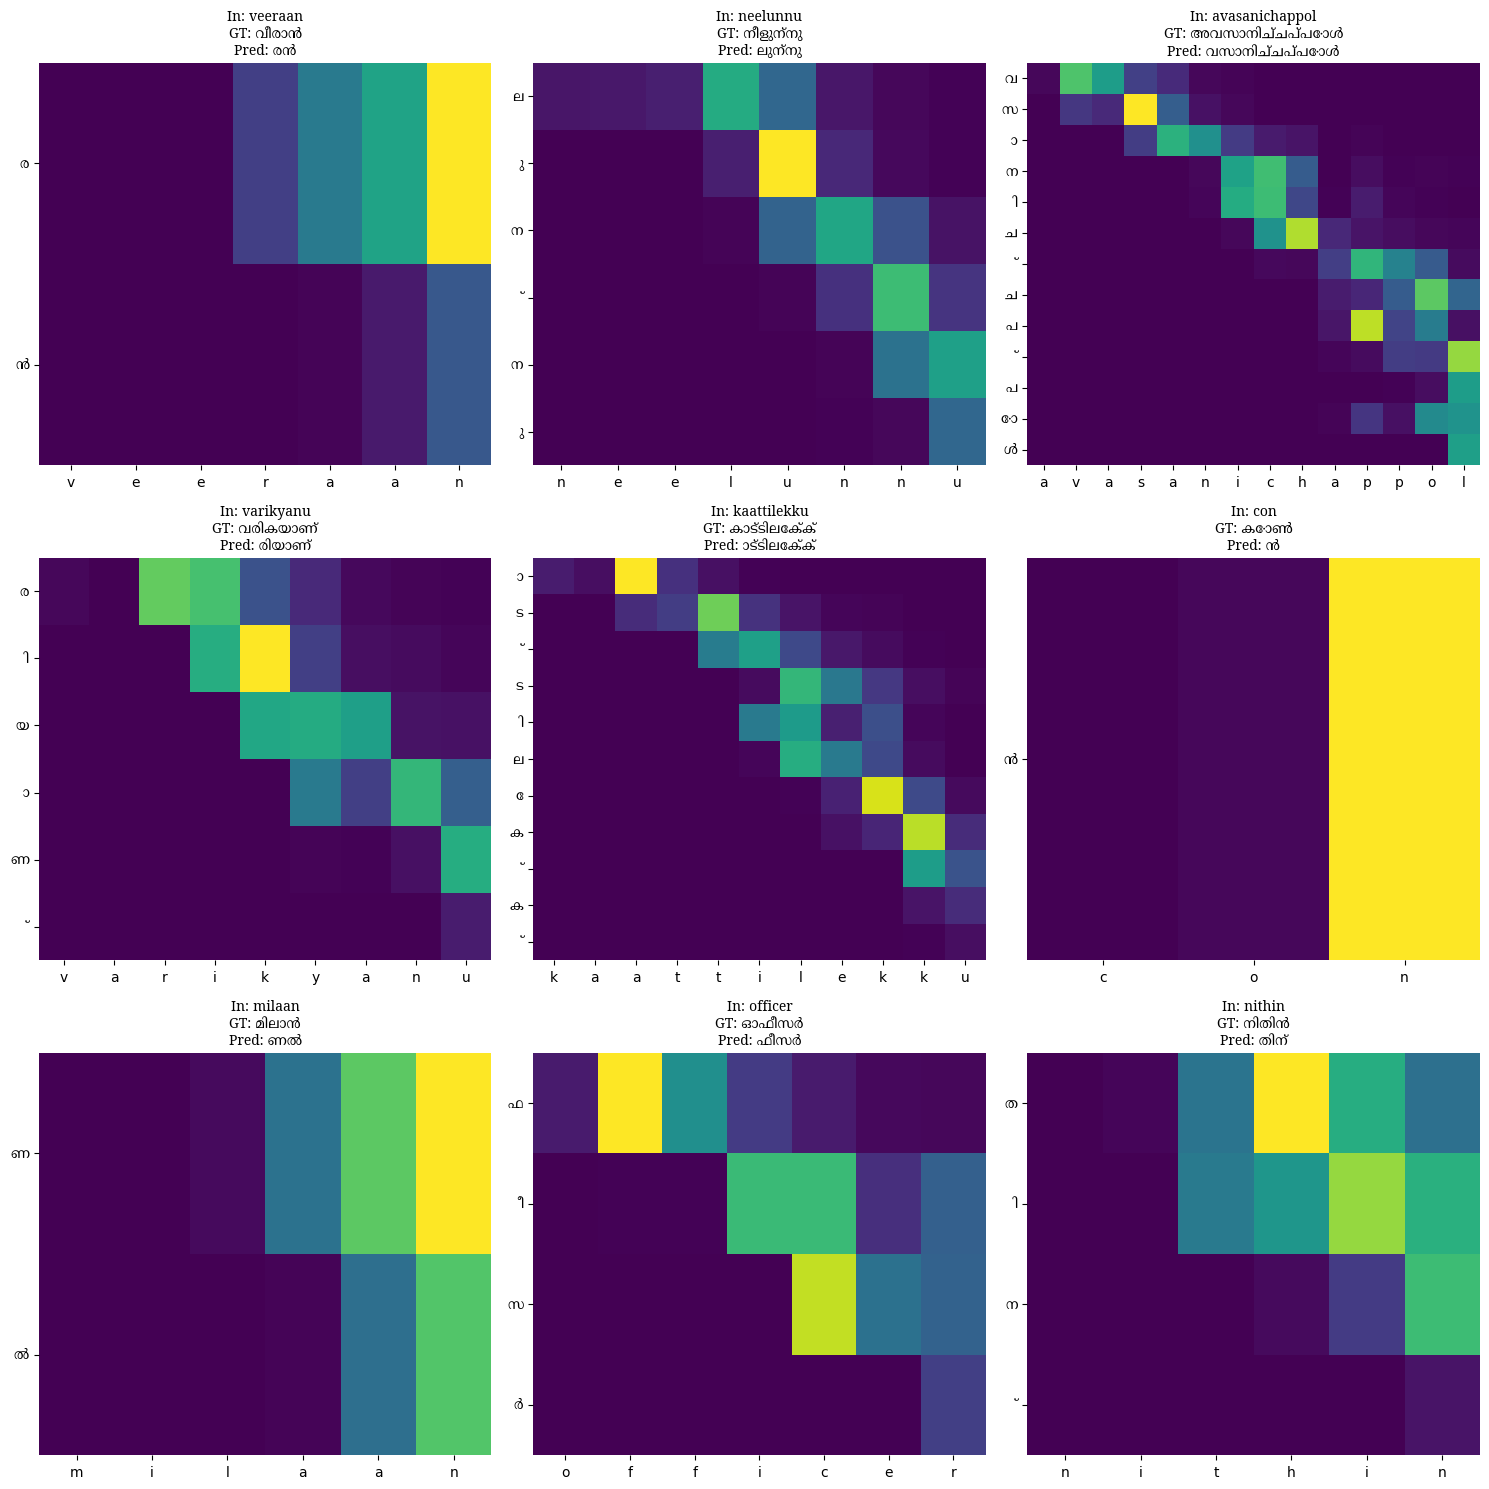

train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇█████
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▅▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_accuracy,74.69426
train_loss,0.01774
val_accuracy,73.4267
val_loss,0.01857


In [29]:
def test():
    with wandb.init() as run:
        config = wandb.config

        # Run name formatting
        wandb.run.name = (
            f"{config.cell_type}-do_{config.dropout}-bs_{config.batch_size}-lr_{config.lr}-"
            f"hs_{config.hidden_size}-emb_{config.inp_embed_size}-")
        
        train_dataloader = get_dataloader(x_train, input_lang, output_lang, wandb.config.batch_size)
        val_dataloader = get_dataloader(x_val, input_lang, output_lang, wandb.config.batch_size)
        test_dataloader = get_dataloader(x_test, input_lang, output_lang, wandb.config.batch_size)
        encoder = EncoderRNN(wandb.config, input_lang.n_letters).to(device)
        decoder = AttnDecoderRNN(wandb.config, output_lang.n_letters).to(device)
        print(input_lang.n_letters, output_lang.n_letters)
        train(train_dataloader, val_dataloader, test_dataloader, encoder, decoder, num_epochs, wandb.config)
        encoder.eval()
        decoder.eval()
        evaluate_and_save_predictions(encoder, decoder)
        
wandb.agent('65xukq3y', function=test, count=1) # calls main function for count number of times. , count=1
wandb.finish() # sweep_id 65xukq3y